In [6]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import tqdm
import arviz as az
import corner

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE, ContinuousSDE, ContinuousVPSDE
from astroddpm.diffusion.stochastic.solver import get_schedule
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom ## For CMB colormap (do not remove)
from astroddpm.moment.models import SigmaMomentModel, SigmaMomentNetwork

## Imports for inference
from inference.cmb_ps import CMBPS
from inference.utils import unnormalize_phi, normalize_phi, log_prior_phi_sigma, sample_prior_phi, log_likelihood_eps_phi_sigma, get_phi_bounds
from inference.hmc import HMC

## Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
## Matplotlib parameters
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

### Loading the diffusion models and Power spectrum model

In [8]:
norm_phi_mode = 'compact'               # Normalization mode for phi among ['compact', 'inf', None]
phi_min, phi_max = get_phi_bounds()     # Bounds on phi (unnormalized)
phi_test = torch.tensor([70, 32.1e-3])  # True phi (unnormalized)
sigma_test = torch.tensor([0.5])        # True sigma

In [9]:
#MODEL_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine' 
## If you want to try really high noise, you can try the one above (did not check if it is good or not, can ask me)
MODEL_ID = 'ContinuousSBM_bottleneck_32_firstc_10_phi_beta_cosine_betamax_2.0_betamin_0.01'
MODEL_ID = 'ContinuousSBM_FFResUNet_bottleneck_32_firstc_10_phi_beta_cosine_betamax_2.0_betamin_0.01'

In [10]:
config = config_from_id(MODEL_ID)
if 'FFResUNet' in MODEL_ID:
    print('FFResUNet')
    config['diffusion_model']['network']['type']='FFResUNet'
    config['diffusion_model']['network']['in_c']=1
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config, also_ckpt=True, for_training=True)
ps_model = CMBPS(norm_input_phi=norm_phi_mode).to(device) 
for parameter in ps_model.parameters():
    parameter.requires_grad = False

FFResUNet
No model id found
Loading the diffuser from a config dict.
{'in_c': 1, 'out_c': 1, 'first_c': 10, 'sizes': [256, 128, 64, 32], 'num_blocks': 1, 'n_steps': 1000, 'time_emb_dim': 100, 'dropout': 0, 'attention': [], 'normalisation': 'GN', 'padding_mode': 'circular', 'eps_norm': 1e-05, 'skiprescale': True, 'type': 'FFResUNet', 'discretization': 'continuous', 'embedding_mode': 'fourier', 'has_phi': True, 'phi_shape': 2, 'phi_embed_dim': 100, 'n_ff_min': 6, 'n_ff_max': 8}
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


### Loading the moment model

In [11]:
MOMENT_MODEL_ID = 'SigmaMomentModel_CMBPS'
ckpt_moment_model = torch.load(os.path.join('/mnt/home/dheurtel/ceph/02_checkpoints/', MOMENT_MODEL_ID, 'ckpt.pt'))

config_moment_model = ckpt_moment_model['config']
moment_network = SigmaMomentNetwork(**config_moment_model['network']).to(device)
config_moment_model['sde'].pop('type')
sde_moment_model = ContinuousVPSDE(**config_moment_model['sde'])
#sde_moment_model.beta_0 = 0.01
#sde_moment_model.beta_T = 0.5
# PS and SDE models are disregarded at inference time
moment_model = SigmaMomentModel(moment_network, sde_moment_model, ps = diffuser.diffmodel.ps).to(device)

moment_model.load_state_dict(ckpt_moment_model['model'])

30 3


<All keys matched successfully>

### Loading the data and building our synthetic superpositions

In [12]:
## Original image

batch = next(iter(diffuser.test_dataloader))
image = batch.unsqueeze(1).to(device)[1:2]

In [13]:
## Parameters for the Gibbs sampler and noise level/timestep

NUM_CHAIN = 8
NOISE_LEVEL = sigma_test.item()
nparams = 3 ## 2 for phi and 1 for sigma
##Closest time step to the noise level requested
TIME_STEP = diffuser.diffmodel.sde.get_closest_timestep(torch.tensor(NOISE_LEVEL))
TIME_STEP = TIME_STEP.to(device)
print(f"Target time step chosen for noise level {NOISE_LEVEL}: {TIME_STEP.item()}")

Target time step chosen for noise level 0.5: 0.5352460145950317


In [14]:
## Target cosmological parameters (and rescaled version)

phi_test_norm = normalize_phi(phi_test[:2], mode=norm_phi_mode).to(device)
print("Normalized test phi:", phi_test_norm)
ps_test = ps_model(phi_test_norm)
sq_ps_test = torch.sqrt(ps_test).to(device)

## Convert to float32
sq_ps_test = sq_ps_test.to(torch.float32)
sq_ps_test.shape

Normalized test phi: tensor([0.5000, 0.5000], device='cuda:0')


torch.Size([1, 256, 256])

In [15]:
## Artificial superposition of CMB and dust map

noisy, mean, noise = diffuser.diffmodel.sde.sampling(image, TIME_STEP, sq_ps_test)
batch_mean = mean.repeat(NUM_CHAIN, 1, 1, 1)
noisy_batch = noisy.repeat(NUM_CHAIN, 1, 1, 1)

batch = image.repeat(NUM_CHAIN, 1, 1, 1) ## Changing the value of batch (we don't need the other images)
#rphi_0 = sample_prior_phi(NUM_CHAIN, norm = norm_phi_mode).to(device)
#phi_0 = unnormalize_phi(rphi_0, mode=norm_phi_mode).to(device)
#rphi_0

In [16]:
#
# Prior, likelihood, and posterior functions
#

sample_prior = lambda n: sample_prior_phi(n, norm=norm_phi_mode, device=device)
log_likelihood = lambda param, x: log_likelihood_eps_phi_sigma(param[:, :2], param[:, 2], x, ps_model)
log_prior = lambda param: log_prior_phi_sigma(param[:, :2], param[:, 2], norm=norm_phi_mode)

def log_posterior(param, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(param, x) + log_prior(param)

## Helpers for HMC bounday management

phi_min_norm, phi_max_norm = get_phi_bounds(device=device)
phi_min_norm, phi_max_norm = normalize_phi(phi_min_norm, mode=norm_phi_mode), normalize_phi(phi_max_norm, mode=norm_phi_mode)
sigma_min, sigma_max = torch.tensor([1e-3]), torch.tensor([1.]) ## Sigma bounds, same as in the prior!!
phi_min_norm = torch.concatenate((phi_min_norm, sigma_min.to(device)))
phi_max_norm = torch.concatenate((phi_max_norm, sigma_max.to(device)))

def collision_manager(q, p, p_nxt):
    p_ret = p_nxt

    for i in range(nparams):
        crossed_min_boundary = q[..., i] < phi_min_norm[i]
        crossed_max_boundary = q[..., i] > phi_max_norm[i]

        # Reflecting boundary conditions
        p_ret[..., i][crossed_min_boundary] = -p[..., i][crossed_min_boundary]
        p_ret[..., i][crossed_max_boundary] = -p[..., i][crossed_max_boundary]

    return p_ret

def boundary_projection(rphi, sigma, eps=1e-3):
    rphi[:,0] = torch.clamp(rphi[:,0], phi_min_norm[0] + eps, phi_max_norm[0] - eps)
    rphi[:,1] = torch.clamp(rphi[:,1], phi_min_norm[1] + eps, phi_max_norm[1] - eps)
    sigma = torch.clamp(sigma, sigma_min.to(device) + eps, sigma_max.to(device) - eps)
    return rphi, sigma


In [17]:
N_GIBBS = 50
BURNIN_HEURISTIC = 1
BURNIN_GIBBS = 0

true_timesteps = TIME_STEP * torch.ones(NUM_CHAIN, dtype=torch.int32).to(device)

In [18]:
phi_list = []
rphi_list = []
sigma_list = []
X_0_list = []
epsilon_hat_list = []
memorize_x0 = True
rescaled_batch = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, true_timesteps)

In [19]:
estimated_param = moment_network(noisy_batch)
rphi = (estimated_param[:, :2]+1)/2
log_sigma = estimated_param[:, 2:]
sigma = torch.exp(log_sigma)
rphi, sigma = boundary_projection(rphi, sigma)
timesteps = diffuser.diffmodel.sde.get_closest_timestep(sigma)[:,0]
phi = unnormalize_phi(rphi, mode=norm_phi_mode).to(device)

progress_bar = tqdm.tqdm(range(N_GIBBS+BURNIN_GIBBS+BURNIN_HEURISTIC))
phi_list.append(phi)
rphi_list.append(rphi)
sigma_list.append(sigma)

timesteps_min = torch.tensor([diffuser.diffmodel.sde.tmin]).to(device).repeat(NUM_CHAIN)
for n in range(N_GIBBS+BURNIN_GIBBS+BURNIN_HEURISTIC):
	schedule = get_schedule('power_law', t_min = timesteps_min, t_max = timesteps, n_iter = 600, power = 2)
	X_0 = diffuser.diffmodel.generate_image(NUM_CHAIN, sample = noisy_batch, schedule = schedule.to(device), verbose=False, phi = phi)
	epsilon_hat = (rescaled_batch - X_0)
	epsilon_hat = epsilon_hat[:, 0, :, :]
	if memorize_x0:
		X_0_list.append(X_0.detach().cpu())
		epsilon_hat_list.append(epsilon_hat.detach().cpu())
	
	log_prob = lambda param: log_posterior(param, epsilon_hat)
	def log_prob_grad(param):
		""" Compute the log posterior and its gradient."""
		param.requires_grad_(True)
		log_prob = log_posterior(param, epsilon_hat)
		grad_log_prob = torch.autograd.grad(log_prob, param, grad_outputs=torch.ones_like(log_prob))[0]
		return log_prob.detach(), grad_log_prob

	rphi = normalize_phi(phi, mode=norm_phi_mode)
	param = torch.cat((rphi, sigma), dim=-1)
	if n < BURNIN_HEURISTIC:
		hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)
		hmc.set_collision_fn(collision_manager)

		samples = hmc.sample(param, nsamples=1, burnin=10, step_size=1e-6, nleap = (5,15), epsadapt=300, verbose = False, ret_side_quantities=False)
		step_size = hmc.step_size
		inv_mass_matrix = hmc.mass_matrix_inv
	else:
		hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)
		hmc.set_collision_fn(collision_manager)
		hmc.set_inv_mass_matrix(inv_mass_matrix, batch_dim=True)
		samples = hmc.sample(param, nsamples=1, burnin=10, step_size=step_size, nleap = (5,15), epsadapt=0, verbose = False)
	
	if (samples[:,0,:] - param == 0).all():
		print('HMC rejecting all')
		break
	## Update the model
	param = samples[:,0,:]
	rphi = param[:, :2]
	sigma = param[:, 2:]
	rphi_list.append(rphi)
	phi = unnormalize_phi(rphi, mode=norm_phi_mode)
	phi_list.append(phi)
	sigma_list.append(sigma)
	phi.detach()
	rphi.detach()
	phi.requires_grad_()
	phi = phi.to(device)
	timesteps = diffuser.diffmodel.sde.get_closest_timestep(sigma)[:,0]
	progress_bar.update(1)
progress_bar.close()

  0%|          | 0/51 [00:00<?, ?it/s]

Adapting step size using 300 iterations
Step size fixed to :  tensor([0.0861, 0.0796, 0.0764, 0.0815, 0.0852, 0.0799, 0.0922, 0.0836],
       device='cuda:0')


100%|██████████| 51/51 [08:03<00:00,  9.48s/it]


## Posterior on the images

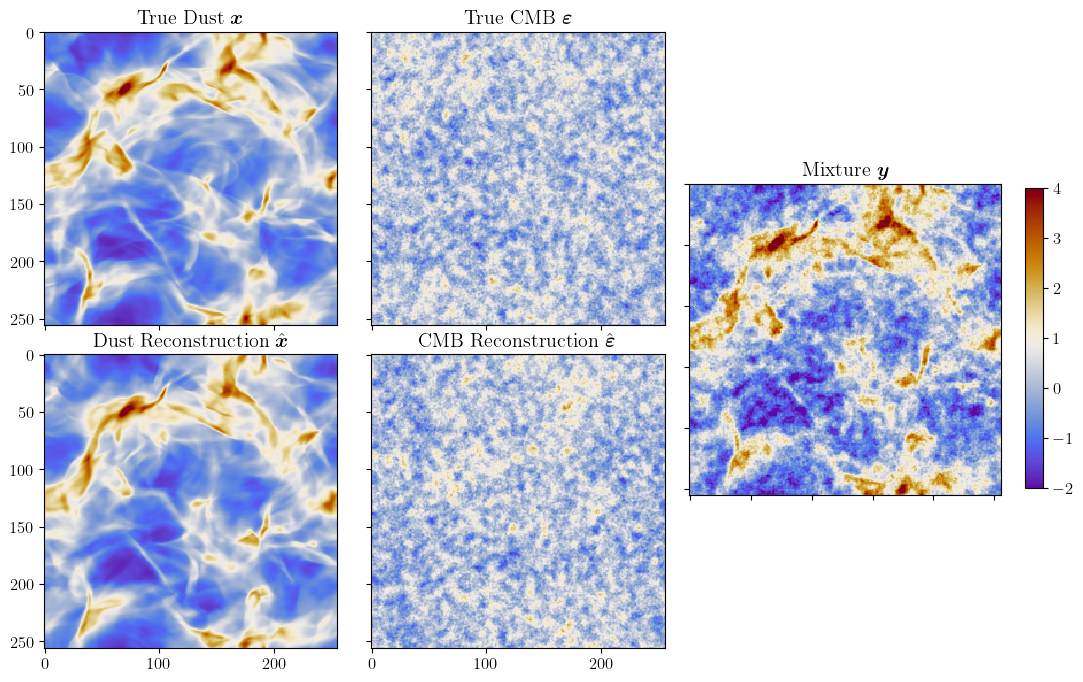

In [141]:
x = image[0, 0].cpu().numpy()
e = (rescaled_batch-image)[0, 0].cpu().numpy()
y = rescaled_batch[0, 0].cpu().numpy()

xh = X_0[0, 0].cpu().numpy()
eh = epsilon_hat[0].cpu().numpy()

vmin = -2
vmax = 4
cmap = 'cmb'

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

gs = axs[0, 2].get_gridspec()

for ax in axs[:, 2]:
    ax.remove()

ax_mixture = fig.add_subplot(gs[:, -1])

im0 = axs[0, 0].imshow(x, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 1].imshow(e, cmap=cmap, vmin=vmin, vmax=vmax)
ax_mixture.imshow(y, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 0].set_title(r'True Dust $\boldsymbol{x}$')
axs[0, 1].set_title(r'True CMB $\boldsymbol{\varepsilon}$')
ax_mixture.set_title(r'Mixture $\boldsymbol{y}$')

# Remove tick labels for ax_mixture
ax_mixture.set_xticklabels([])
ax_mixture.set_yticklabels([])

axs[1, 0].imshow(xh, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 1].imshow(eh, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 0].set_title(r'Dust Reconstruction $\hat{\boldsymbol{x}}$')
axs[1, 1].set_title(r'CMB Reconstruction $\hat{\boldsymbol{\varepsilon}}$')

fig.colorbar(im0, cax=fig.add_axes([0.95, 0.31, 0.015, 0.375])) # left, bottom, width, height
fig.subplots_adjust(right=0.93, wspace=0.05, hspace=0.1)
if save_fig:
    fig.savefig('figs/cosmo_mixture_and_recons.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'CMB posterior std $\\text{Var}[\\hat{\\boldsymbol{\\varepsilon}}]$')

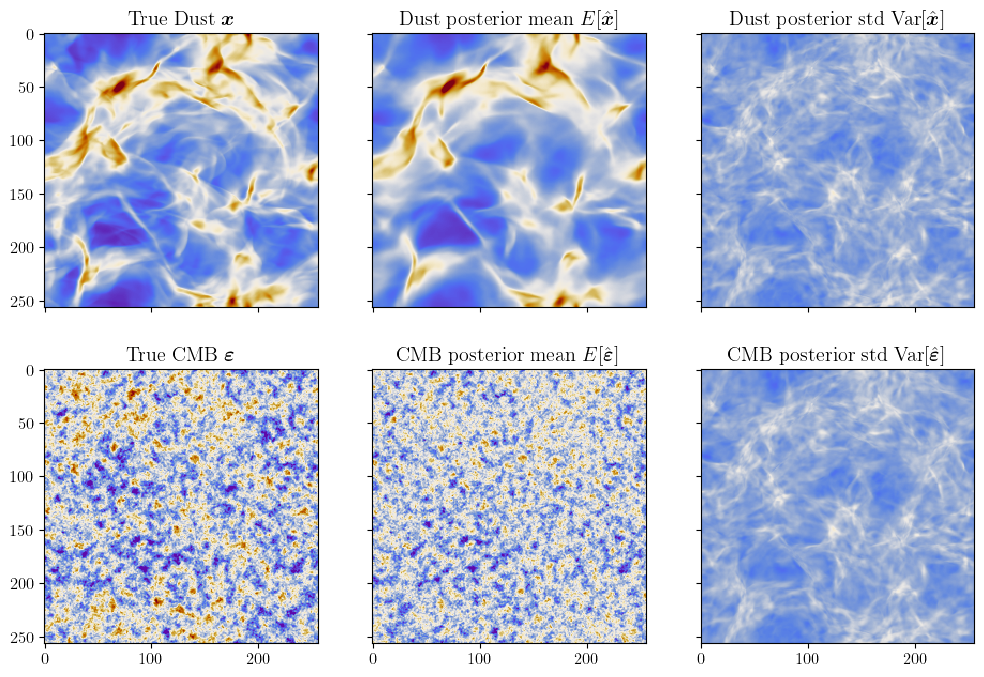

In [46]:
vmin_dust, vmax_dust = -2, 4
vmin_cmb, vmax_cmb = -1, 2

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

axs[0, 0].imshow(x, cmap=cmap, vmin=vmin_dust, vmax=vmax_dust)
axs[0, 0].set_title(r'True Dust $\boldsymbol{x}$')
axs[1, 0].imshow(e, cmap=cmap, vmin=vmin_cmb, vmax=vmax_cmb)
axs[1, 0].set_title(r'True CMB $\boldsymbol{\varepsilon}$')
all_x = torch.stack(X_0_list, dim=0)
all_epsilon = torch.stack(epsilon_hat_list, dim=0)
posterior_mean_x = torch.mean(all_x, dim=0)[0, 0].cpu().numpy()
posterior_mean_epsilon = torch.mean(all_epsilon, dim=0)[0].cpu().numpy()
posterior_std_x = torch.std(all_x, dim=0)[0, 0].cpu().numpy()
posterior_std_epsilon = torch.std(all_epsilon, dim=0)[0].cpu().numpy()

axs[0, 1].imshow(posterior_mean_x, cmap=cmap, vmin=vmin_dust, vmax=vmax_dust)
axs[0, 1].set_title(r'Dust posterior mean $E[\hat{\boldsymbol{x}}]$')
axs[1, 1].imshow(posterior_mean_epsilon, cmap=cmap, vmin=vmin_cmb, vmax=vmax_cmb)
axs[1, 1].set_title(r'CMB posterior mean $E[\hat{\boldsymbol{\varepsilon}}]$')
axs[0, 2].imshow(posterior_std_x, cmap=cmap, vmin=0, vmax=vmax_dust/4)
axs[0, 2].set_title(r'Dust posterior std $\text{Var}[\hat{\boldsymbol{x}}]$')
axs[1, 2].imshow(posterior_std_epsilon, cmap=cmap, vmin=0, vmax=vmax_cmb/2)
axs[1, 2].set_title(r'CMB posterior std $\text{Var}[\hat{\boldsymbol{\varepsilon}}]$')

## Posterior on the parameters

In [47]:
tensor_rphi_list = [rphi.unsqueeze(0) for rphi in rphi_list]
tensor_rphi_list = torch.cat(tensor_rphi_list, dim=0)
tensor_rphi_list.shape

torch.Size([52, 8, 2])

In [52]:
tensor_phi_list = [phi.unsqueeze(0) for phi in phi_list]
tensor_phi_list = torch.cat(tensor_phi_list, dim=0)
tensor_phi_list.shape

torch.Size([52, 8, 2])

In [53]:
tensor_sigma_list = [sigma.unsqueeze(0) for sigma in sigma_list]
tensor_sigma_list = torch.cat(tensor_sigma_list, dim=0)
tensor_sigma_list.shape

torch.Size([52, 8, 1])

In [136]:
burnin = 10
tensor_phi_all = tensor_phi_list[burnin:].detach().cpu().numpy()
tensor_sigma_all = tensor_sigma_list[burnin:].detach().cpu().numpy()
tensor_params_all = np.concatenate((tensor_phi_all, tensor_sigma_all), axis=-1)
print(tensor_phi_all.shape, tensor_sigma_all.shape, tensor_params_all.shape)

params_truth = torch.cat((phi_test.cpu(), sigma_test.cpu()), dim=-1).detach().cpu().numpy()
print(params_truth)

ess = np.zeros((nparams))
rhat = np.zeros((nparams))

az_infdata = az.convert_to_inference_data(tensor_params_all.transpose(1, 0, 2))
ess = az.ess(az_infdata)['x'].values
rhat = az.rhat(az_infdata)['x'].values

print(ess)
print(rhat)

tensor_params_all = tensor_params_all.reshape(-1, nparams)

(42, 8, 2) (42, 8, 1) (42, 8, 3)
[7.00e+01 3.21e-02 5.00e-01]
[240.14856382 236.75314521 252.36297331]
[1.00023832 1.01500943 1.00577487]


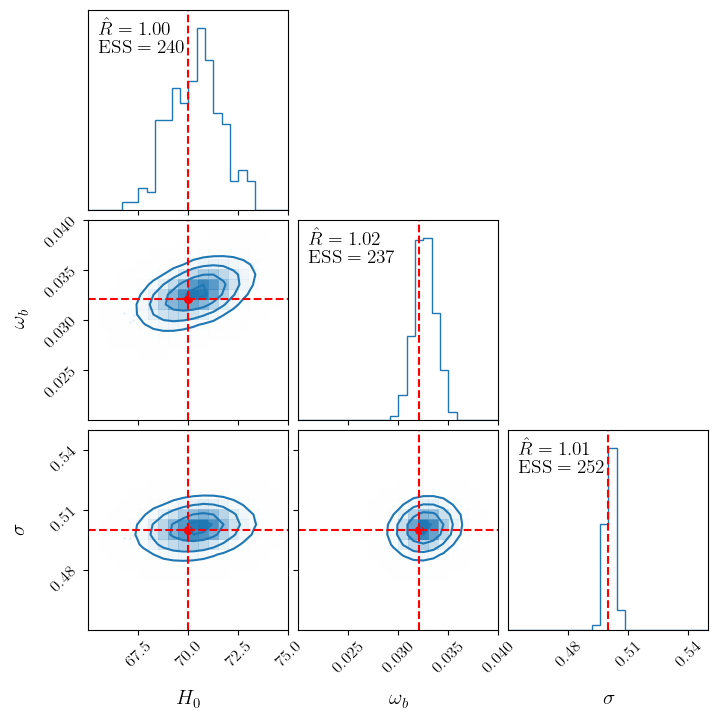

In [142]:
# Corner plot

labels = [r'$H_0$', r'$\omega_b$', r'$\sigma$']

fig = corner.corner(tensor_params_all, labels=labels, show_titles=False, color='C0', hist_kwargs={'color':'C0', 'density':True}, smooth=1.5, hist_bin_factor=1.2, range=[(65, 75), (0.02, 0.04), (0.45, 0.55)], label_kwargs={'fontsize':15}, max_n_ticks=4)
axes = fig.get_axes()
for i in range(3):
    for j in range(3):
        if i > j:
            axes[i*3+j].axvline(params_truth[j], color='r', linestyle='--')
            axes[i*3+j].axhline(params_truth[i], color='r', linestyle='--')
            axes[i*3+j].scatter(params_truth[j], params_truth[i], color='r', s=30)
        if i == j:
            axes[i*3+j].axvline(params_truth[j], color='r', linestyle='--')
            # Add Rhat and ESS
            axes[i*3+j].text(0.05, 0.95, r'$\hat{{R}} = {:.2f}$'.format(rhat[j]), transform=axes[i*3+j].transAxes, fontsize=14, verticalalignment='top')
            axes[i*3+j].text(0.05, 0.85, r'$\text{{ESS}} = {:.0f}$'.format(ess[j]), transform=axes[i*3+j].transAxes, fontsize=14, verticalalignment='top')
if save_fig:
    fig.savefig('figs/cosmo_inference.pdf', bbox_inches='tight')

## Full cosmological inference

(0.0, 1.0)

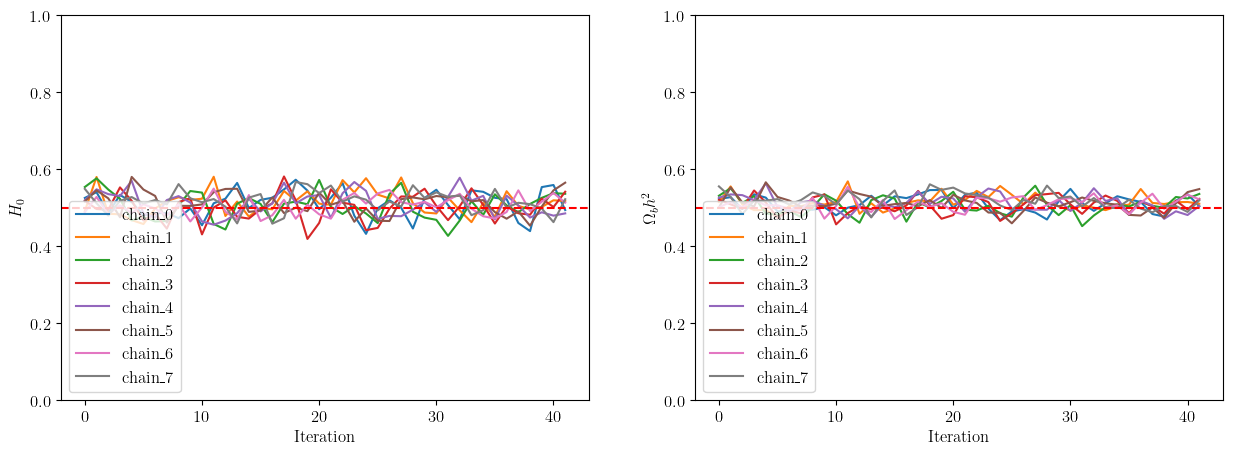

In [118]:
### Trace plots for these chains
num_chains = tensor_rphi_list.shape[1]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(num_chains):
    ax[0].plot(tensor_rphi_list[0:, i, 0].detach().cpu().numpy(), label = 'chain_{}'.format(i))
    ax[1].plot(tensor_rphi_list[0:, i, 1].detach().cpu().numpy(), label = 'chain_{}'.format(i))
ax[0].axhline(phi_test_norm[0].detach().cpu().numpy(), color='red', linestyle='--')
ax[1].axhline(phi_test_norm[1].detach().cpu().numpy(), color='red', linestyle='--')
ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel(r"$H_0$")
ax[1].set_ylabel(r"$\Omega_b h^2$")
ax[0].legend()
ax[1].legend()
## Set limits to 0,1
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)

In [143]:
noisy_image_additive = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, timesteps)
estimated_noise = noisy_image_additive - X_0
added_noise_additive = noisy_image_additive - image

In [144]:
##
## COMPUTTATION OF THE POWER SPECTRUM
##
## Compute power spectrum
bins = torch.linspace(0, np.pi, 100).to(device)

bins_centers = (bins[:-1] + bins[1:])/2
bins_centers = bins_centers.cpu()
mean_list = []
std_list = []
for data in [image, noisy_image_additive, added_noise_additive, X_0, estimated_noise]:
    mean_, std_ , bins = powerSpectrum.set_power_spectrum_iso2d(data.to(device), bins, use_gpu=True)
    mean_list.append(mean_)
    std_list.append(std_)

## Compute the power spectrum of the posterior mean over phi

interesting_chains = [2,4]
interesting_chains = [0,1,3,5,6]
H0_mean = tensor_rphi_list[10:, interesting_chains, 0].mean()
Obh2_mean = tensor_rphi_list[10:, interesting_chains, 1].mean()

phi_mean = torch.tensor([H0_mean, Obh2_mean]).reshape(1,2).to(device)

ps_mean = ps_model(phi_mean).unsqueeze(1) * NOISE_LEVEL**2 * 256**2

mean_list.append(powerSpectrum._spectral_iso2d(ps_mean, bins, use_gpu=True)[1].reshape(-1))
std_list.append(torch.zeros_like(mean_list[-1]))

## Compute the power spectrum of phi_true

ps_true = ps_model(phi_test_norm).unsqueeze(1) * NOISE_LEVEL**2 * 256**2

mean_list.append(powerSpectrum._spectral_iso2d(ps_true, bins, use_gpu=True)[1].reshape(-1))
std_list.append(torch.zeros_like(mean_list[-1]))

mean_list = [mean.cpu().numpy() for mean in mean_list]
std_list = [std.cpu().numpy() for std in std_list]

In [145]:
ps_bins = bins_centers.cpu()
ps_mean_list = [mean[:-1] for mean in mean_list]
ps_std_list = [std[:-1] for std in std_list]

In [146]:
ps_orig = ps_mean_list[0]
ps_orig_std = ps_std_list[0]
ps_noisy = ps_mean_list[1]
ps_noisy_std = ps_std_list[1]
ps_noise = ps_mean_list[2]
ps_noise_std = ps_std_list[2]
ps_denoised = ps_mean_list[3]
ps_denoised_std = ps_std_list[3]
ps_estimated_noise = ps_mean_list[4]
ps_estimated_noise_std = ps_std_list[4]
ps_posterior_mean = ps_mean_list[5]
ps_posterior_mean_std = ps_std_list[5]
ps_true = ps_mean_list[6]
ps_true_std = ps_std_list[6]

In [148]:
ps_list = [ps_noisy, ps_orig, ps_denoised, ps_noise, ps_estimated_noise]
ps_std_list = [ps_noisy_std, ps_orig_std, ps_denoised_std, ps_noise_std, ps_estimated_noise_std]
ps_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
ps_labels = [r'Mixture $\mathbf{y}$',
             r'True Dust $\mathbf{x}$',
             r'Reconstructed Dust $\hat{\mathbf{x}}$',
             r'True CMB $\mathbf{\varepsilon}$',
             r'Reconstructed CMB $\hat{\mathbf{\varepsilon}}$']

ps_rel_error_list = [np.abs(ps_denoised/ps_orig - 1), np.abs(ps_estimated_noise/ps_noise - 1)]
ps_rel_color = ['C2', 'C4']

Text(0.5, 1.0, 'Power spectrum')

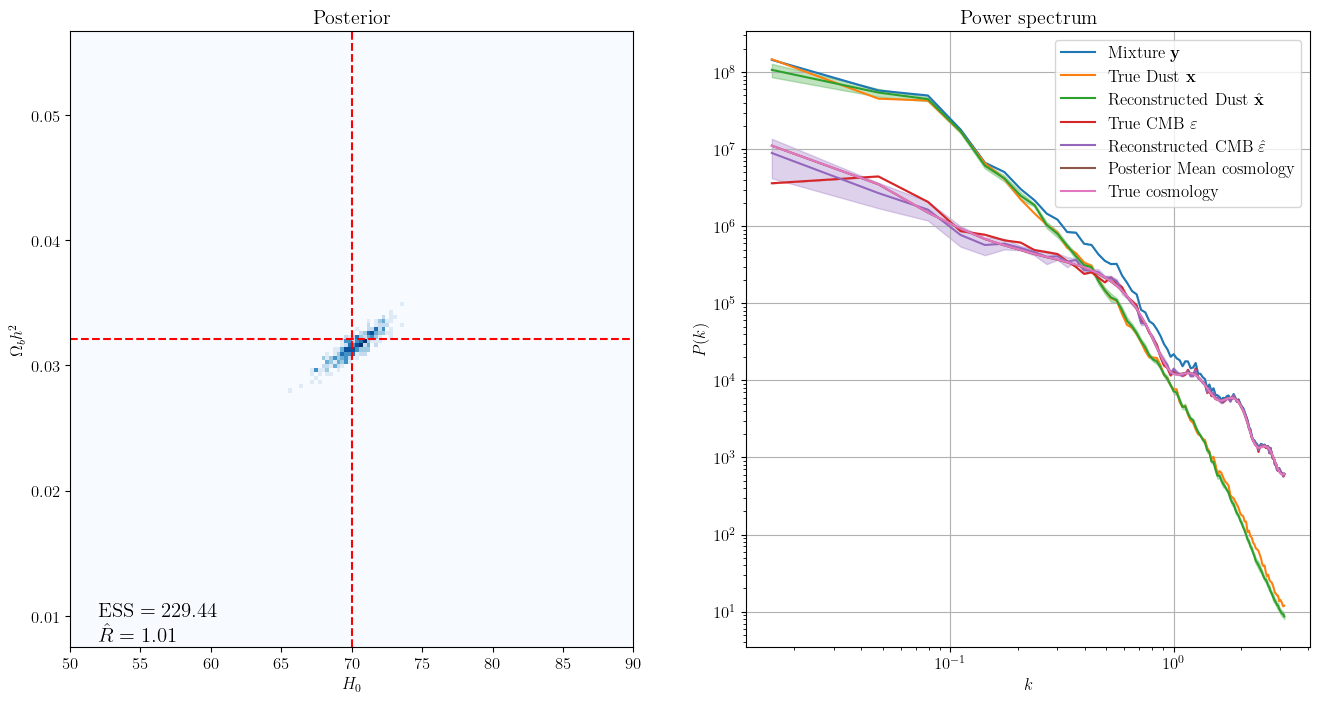

In [37]:
fig, axs = plt.subplots(2, 1, height_ratios=[0.8, 0.2], sharex=True)

for i in range(len(ps_list)):
    axs[0].plot(ps_bins, ps_list[i], color=ps_colors[i], label=ps_labels[i])
    axs[0].fill_between(ps_bins, ps_list[i]-ps_std_list[i], ps_list[i]+ps_std_list[i], alpha=0.2, color=ps_colors[i])

axs[0].set_ylabel(r'$P(k)$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

for i in range(len(ps_rel_error_list)):
    axs[1].plot(ps_bins, ps_rel_error_list[i], color=ps_rel_color[i])

axs[1].set_ylabel(r'Rel. Error')
axs[1].set_xlabel(r'$k$')

if save_fig:
    plt.savefig('figs/cosmo_ps.pdf', bbox_inches='tight')